In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Load and preprocess data
df = pd.read_csv('newdata.csv')
df.head()

,Time,Day,Temp,Humidity,Light_Intensity,Occupancy,Energy
0,20:00,Saturday,12.400000,40.400000,0.000000,1,4.640313
1,23:00,Thursday,12.401275,40.403142,0.104842,1,4.700506
2,1:40,Monday,12.402550,40.406284,0.209684,1,4.824251
3,2:00,Saturday,12.403825,40.409426,0.314526,1,4.886108
4,20:00,Wednesday,12.405100,40.412568,0.419368,1,4.958296


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             12000 non-null  object 
 1   Day              12000 non-null  object 
 2   Temp             12000 non-null  float64
 3   Humidity         12000 non-null  float64
 4   Light_Intensity  12000 non-null  float64
 5   Occupancy        12000 non-null  int64  
 6   Energy           12000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 656.4+ KB


In [5]:
# Feature Engineering
df['Minutes'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour * 60 + \
                pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.minute
df['Hour'] = df['Minutes'] // 60
df['Is_Weekend'] = (pd.to_datetime(df['Time'], format='%H:%M').dt.weekday >= 5).astype(int)
df['Temp_Humidity'] = df['Temp'] * df['Humidity']
df['Light_Occupancy'] = df['Light_Intensity'] * df['Occupancy']
df['Temp_Light'] = df['Temp'] * df['Light_Intensity']
df['Temp_Occupancy'] = df['Temp'] * df['Occupancy']
df['Humidity_Light'] = df['Humidity'] * df['Light_Intensity']
df['Energy_Lag1'] = df['Energy'].shift(1)
df['Temp_Lag1'] = df['Temp'].shift(1)
df['Humidity_Lag1'] = df['Humidity'].shift(1)
df['Energy_Lag2'] = df['Energy'].shift(2)
df['Temp_RollingMean3'] = df['Temp'].rolling(window=3).mean()
df['Humidity_RollingMean3'] = df['Humidity'].rolling(window=3).mean()
df.dropna(inplace=True)
df = pd.get_dummies(df, columns=['Day'], drop_first=True)

In [6]:
# Define features and target
features = ['Minutes', 'Temp', 'Humidity', 'Light_Intensity', 'Occupancy', 'Temp_Humidity', 'Light_Occupancy',
            'Temp_Light', 'Temp_Occupancy', 'Humidity_Light', 'Is_Weekend', 'Energy_Lag1', 'Temp_Lag1', 
            'Humidity_Lag1', 'Energy_Lag2', 'Temp_RollingMean3', 'Humidity_RollingMean3'] + [
                col for col in df.columns if col.startswith('Day_')
            ]

X = df[features].values
y = df['Energy'].values
print(X.shape, y.shape)

(11998, 23) (11998,)


In [27]:
pd.set_option('display.max_columns', None)
df[features]

,Minutes,Temp,Humidity,Light_Intensity,Occupancy,Temp_Humidity,Light_Occupancy,Temp_Light,Temp_Occupancy,Humidity_Light,Is_Weekend,Energy_Lag1,Temp_Lag1,Humidity_Lag1,Energy_Lag2,Temp_RollingMean3,Humidity_RollingMean3,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
2,100,12.402550,40.406284,0.209684,1,501.140964,0.209684,2.600618,12.402550,8.472557,0,4.700506,12.401275,40.403142,4.640313,12.401275,40.403142,True,False,False,False,False,False
3,120,12.403825,40.409426,0.314526,1,501.231459,0.314526,3.901328,12.403825,12.709824,0,4.824251,12.402550,40.406284,4.700506,12.402550,40.406284,False,True,False,False,False,False
4,1200,12.405100,40.412568,0.419368,1,501.321961,0.419368,5.202306,12.405100,16.947749,0,4.886108,12.403825,40.409426,4.824251,12.403825,40.409426,False,False,False,False,False,True
5,120,12.406376,40.415710,0.524210,1,501.412471,0.524210,6.503550,12.406376,21.186333,0,4.958296,12.405100,40.412568,4.886108,12.405100,40.412568,True,False,False,False,False,False
6,1400,12.407651,40.418852,0.629052,1,501.502990,0.629052,7.805063,12.407651,25.425576,0,5.035205,12.406376,40.415710,4.958296,12.406376,40.415710,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,360,27.694900,78.087432,1257.580632,1,2162.623595,1257.580632,34828.569304,27.694900,98201.242451,0,3.641871,27.693624,78.084290,3.554888,27.693624,78.084290,False,False,False,True,False,False
11996,440,27.696175,78.090574,1257.685474,1,2162.810184,1257.685474,34833.076580,27.696175,98213.380840,0,3.676482,27.694900,78.087432,3.641871,27.694900,78.087432,False,False,False,True,False,False
11997,100,27.697450,78.093716,1257.790316,1,2162.996782,1257.790316,34837.584124,27.697450,98225.519901,0,3.666963,27.696175,78.090574,3.676482,27.696175,78.090574,False,False,False,True,False,False
11998,920,27.698725,78.096858,1257.895158,1,2163.183386,1257.895158,34842.091922,27.698725,98237.659621,0,3.707406,27.697450,78.093716,3.666963,27.697450,78.093716,False,False,False,False,False,True


In [9]:
# Scale data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [10]:
# Create sequences for GRU
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 15
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [11]:
# Build GRU Model
def build_gru_model(input_shape):
    model = Sequential([
        Bidirectional(GRU(128, activation='tanh', return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        BatchNormalization(),
        GRU(64, activation='tanh', return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

gru_model = build_gru_model((seq_length, X_train.shape[2]))

c:\Users\Dell\anaconda3\envs\raqib\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Train GRU Model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

gru_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, lr_reduction],
    verbose=1
)

Epoch 1/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 37s 66ms/step - loss: 0.0699 - mae: 0.1986 - val_loss: 0.0330 - val_mae: 0.1455 - learning_rate: 0.0010
Epoch 2/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0158 - mae: 0.0977 - val_loss: 0.0054 - val_mae: 0.0535 - learning_rate: 0.0010
Epoch 3/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0111 - mae: 0.0821 - val_loss: 0.0063 - val_mae: 0.0625 - learning_rate: 0.0010
Epoch 4/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.0086 - mae: 0.0721 - val_loss: 0.0051 - val_mae: 0.0548 - learning_rate: 0.0010
Epoch 5/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0081 - mae: 0.0688 - val_loss: 0.0062 - val_mae: 0.0660 - learning_rate: 0.0010
Epoch 6/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 0.0075 - mae: 0.0669 - val_loss: 0.0072 - val_mae: 0.0689 - learning_rate: 0.0010
Epoch 7/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0074 - mae: 0.0665 - val_loss: 0.0024 - val_mae: 0.0352 - learning

In [13]:
# Monte Carlo Dropout for Uncertainty Estimation
def monte_carlo_predictions(model, X_test, num_samples=100):
    preds = np.array([model.predict(X_test, verbose=0) for _ in range(num_samples)])
    mean_pred = preds.mean(axis=0)
    uncertainty = preds.std(axis=0)
    return mean_pred, uncertainty

gru_pred_scaled, uncertainty_scaled = monte_carlo_predictions(gru_model, X_test)
gru_pred = scaler_y.inverse_transform(gru_pred_scaled)
uncertainty = scaler_y.inverse_transform(uncertainty_scaled)

In [15]:
# Train Random Forest Regressor
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [16]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)

c:\Users\Dell\anaconda3\envs\raqib\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [17]:
rf_pred_scaled = rf_model.predict(X_test_flat)
rf_pred = scaler_y.inverse_transform(rf_pred_scaled.reshape(-1, 1))

In [18]:
# Combine GRU and Random Forest Predictions
gru_weight = 0.7
rf_weight = 0.3
ensemble_pred = (gru_weight * gru_pred) + (rf_weight * rf_pred)

In [19]:
# Evaluate Ensemble Predictions
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
ensemble_rmse = np.sqrt(mean_squared_error(y_test_actual, ensemble_pred))
ensemble_mae = mean_absolute_error(y_test_actual, ensemble_pred)
ensemble_r2 = r2_score(y_test_actual, ensemble_pred)
ensemble_mape = np.mean(np.abs((y_test_actual - ensemble_pred) / y_test_actual)) * 100

print("\nEnsemble Model Performance:")
print(f"Root Mean Square Error (RMSE): {ensemble_rmse:.3f}")
print(f"Mean Absolute Error (MAE): {ensemble_mae:.3f} kWh")
print(f"R-squared Score: {ensemble_r2:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {ensemble_mape:.2f}%")


Ensemble Model Performance:
Root Mean Square Error (RMSE): 0.252
Mean Absolute Error (MAE): 0.181 kWh
R-squared Score: 0.989
Mean Absolute Percentage Error (MAPE): 2.74%


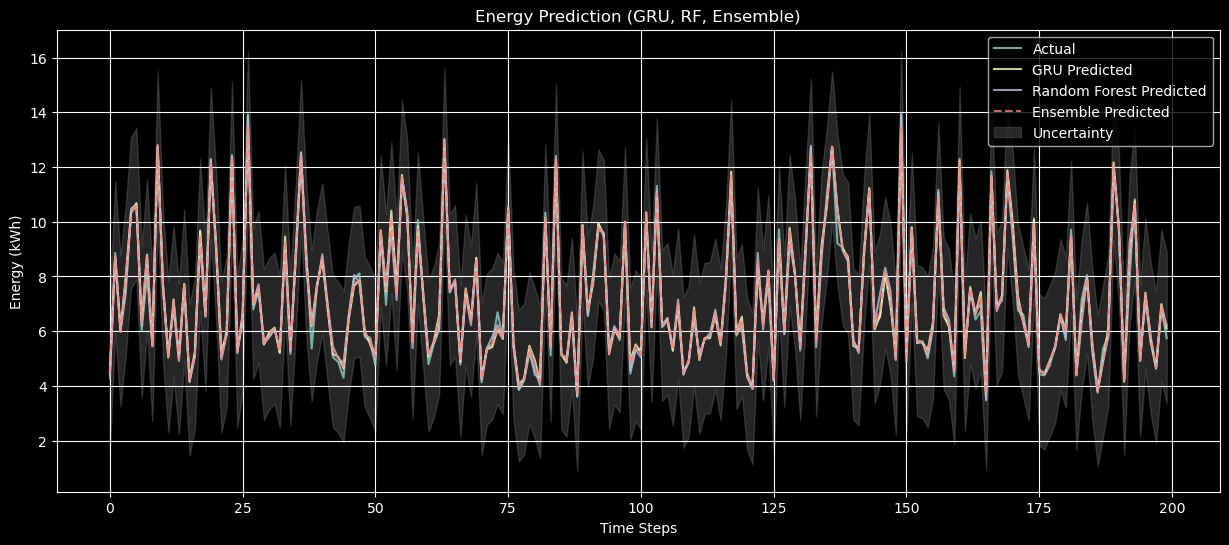

In [20]:
# Visualize Predictions
def plot_ensemble_predictions(y_test_actual, gru_pred, rf_pred, ensemble_pred, uncertainty, num_points=200):
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_actual[:num_points], label='Actual', alpha=0.8)
    plt.plot(gru_pred[:num_points], label='GRU Predicted', alpha=0.8)
    plt.plot(rf_pred[:num_points], label='Random Forest Predicted', alpha=0.8)
    plt.plot(ensemble_pred[:num_points], label='Ensemble Predicted', alpha=0.8, linestyle='--')
    plt.fill_between(
        np.arange(num_points),
        (ensemble_pred - uncertainty)[:num_points].flatten(),
        (ensemble_pred + uncertainty)[:num_points].flatten(),
        color='gray', alpha=0.3, label='Uncertainty'
    )
    plt.title('Energy Prediction (GRU, RF, Ensemble)')
    plt.xlabel('Time Steps')
    plt.ylabel('Energy (kWh)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_ensemble_predictions(y_test_actual, gru_pred, rf_pred, ensemble_pred, uncertainty)

 """ see the ouput
Ensemble Model Performance:
Root Mean Square Error (RMSE): 0.231
Mean Absolute Error (MAE): 0.163 kWh
R-squared Score: 0.991
Mean Absolute Percentage Error (MAPE): 2.39% 
 """

## Save models

In [29]:
scaler_X

MinMaxScaler()

In [28]:
# Save GRU model
gru_model.save('gru_model.keras')

# Save Random Forest model and scalers
import joblib

# Save the feature list without 'Day_Monday' since it's the reference category
features = ['Minutes', 'Temp', 'Humidity', 'Light_Intensity', 'Occupancy', 
           'Temp_Humidity', 'Light_Occupancy', 'Temp_Light', 'Temp_Occupancy', 
           'Humidity_Light', 'Is_Weekend', 'Energy_Lag1', 'Temp_Lag1', 
           'Humidity_Lag1', 'Energy_Lag2', 'Temp_RollingMean3', 
           'Humidity_RollingMean3'] + [col for col in df.columns if col.startswith('Day_')]

joblib.dump(rf_model, 'random_forest_model.joblib')
joblib.dump(scaler_X, 'feature_scaler.joblib')
joblib.dump(scaler_y, 'target_scaler.joblib')

# Save model parameters
model_params = {
    'seq_length': seq_length,
    'gru_weight': gru_weight,
    'rf_weight': rf_weight,
    'features': features
}
joblib.dump(model_params, 'model_params.joblib')

['model_params.joblib']

In [30]:
# Save GRU model
gru_model.save('gru_model.keras')

# For Random Forest, we need to flatten the sequence data structure
X_train_rf = X_train.reshape(X_train.shape[0], -1)  # Flatten the sequences
rf_model.fit(X_train_rf, y_train)  # Retrain on flattened data

# Save models and parameters
joblib.dump(rf_model, 'random_forest_model.joblib')
joblib.dump(scaler_X, 'feature_scaler.joblib')
joblib.dump(scaler_y, 'target_scaler.joblib')

# Save the sequence length and features information
model_params = {
    'seq_length': seq_length,
    'gru_weight': gru_weight,
    'rf_weight': rf_weight,
    'features': features,
    'input_dim': X_train.shape[2]  # Number of features per timestep
}
joblib.dump(model_params, 'model_params.joblib')

c:\Users\Dell\anaconda3\envs\raqib\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


['model_params.joblib']